# Meta

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
path = "/content/drive/MyDrive/Colab Notebooks/"

In [ ]:
!pip uninstall lightgbm
!pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

Uninstalling lightgbm-3.2.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/lightgbm-3.2.1-py3.7.egg-info
    /usr/local/lib/python3.7/dist-packages/lightgbm/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/lightgbm/lib_lightgbm.so
Proceed (y/n)? y
  Successfully uninstalled lightgbm-3.2.1
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
  Using cached https://files.pythonhosted.org/packages/7a/6d/db0f5effd3f7982632111f37fcd2fa386b8407f1ff58ef30b71d65e1a444/lightgbm-3.2.1.tar.gz
Skipping wheel build for lightgbm, due to binaries being disabled for it.
    Running setup.py install for lightgbm ... done


In [67]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd

from scipy.sparse import hstack, load_npz

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import lightgbm as lgb
#from preprocessing import cv_ize

In [4]:
X = range(0, 40000)
Y = pd.read_csv(path+"data/recipe_train.csv")['duration_label']

X_idx, X_t_idx, y, y_t = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
X_50 = np.array(pd.read_csv(path+"data/vec50/train_steps_doc2vec50.csv", header=None).iloc[X_idx])
X_t_50 = np.array(pd.read_csv(path+"data/vec50/train_steps_doc2vec50.csv", header=None).iloc[X_t_idx])

X_100 = np.array(pd.read_csv(path+"data/vec100/train_steps_doc2vec100.csv", header=None).iloc[X_idx])
X_t_100 = np.array(pd.read_csv(path+"data/vec100/train_steps_doc2vec100.csv", header=None).iloc[X_t_idx])

In [ ]:
X_cv = pd.read_csv(path+"data/recipe_train.csv", header=0).iloc[X_idx].loc[:, 'steps']
X_t_cv = pd.read_csv(path+"data/recipe_train.csv", header=0).iloc[X_t_idx].loc[:, 'steps']

In [ ]:
X_cv, X_t_cv, d = cv_ize(X_cv, X_t_cv, var_thre=0)

Extracted 354464 grams.


In [ ]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.0003)

X_cv = selector.fit_transform(X_cv)
X_t_cv = selector.transform(X_t_cv)

In [ ]:
X_cv = X_cv.toarray().astype(np.float16)
X_t_cv = X_t_cv.toarray().astype(np.float16)

In [ ]:
X_cv.shape

(32000, 33469)

In [5]:
X_vec = np.hstack((
    pd.read_csv(path+"data/vec50/train_steps_doc2vec50.csv", header=None).values,
    pd.read_csv(path+"data/vec50/train_name_doc2vec50.csv", header=None).values,
    pd.read_csv(path+"data/vec50/train_ingr_doc2vec50.csv", header=None).values,
    
    pd.read_csv(path+"data/vec100/train_steps_doc2vec100.csv", header=None).values,
    pd.read_csv(path+"data/vec100/train_name_doc2vec100.csv", header=None).values,
    pd.read_csv(path+"data/vec100/train_ingr_doc2vec100.csv", header=None).values
))


In [6]:
X_t_vec = X_vec[X_t_idx]
X_vec = X_vec[X_idx]

In [7]:
X_vec.shape

(32000, 450)

# SVM

In [42]:
X_small = X_vec[:9000]
y_small = y[:9000]

In [ ]:
import time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

start = time.time()
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf.fit(X_small, y_small)
end = time.time()

In [15]:
print("Single SVC", end - start, clf.score(X_t_vec,y_t))
#proba = clf.predict_proba(X_t_vec)

Single SVC 316.5651080608368 0.633


In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [48]:
results = []
for c in [5000, 1000, 100, 50]:
  for g in [1e-5, 1e-4, 1e-3, 1e-2]:
      
      n_estimators = 12
      clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='rbf', gamma=g, C=c, class_weight='balanced', max_iter=2000), n_jobs=-1, max_samples=1.0 / n_estimators, n_estimators=n_estimators))
      
      start = time.time()
      clf.fit(X_small, y_small)
      end = time.time()
      t = end-start
      acc  = clf.score(X_t_vec, y_t)
      #cv_results = cross_validate(clf, X_small, y_small, cv=3)
      #t = sum(cv_results['fit_time'])/len(cv_results['fit_time'])
      #acc = cv_results['test_score']
      #results.append([c, g, n, t, acc])

      print(f"c: {c}, g: {g}, time:{t}, acc: {acc}")

#proba = clf.predict_proba(X_t_vec)

c: 5000, g: 1e-05, time:8.120466232299805, acc: 0.691125
c: 5000, g: 0.0001, time:7.488362073898315, acc: 0.69675
c: 5000, g: 0.001, time:7.63664984703064, acc: 0.702125
c: 5000, g: 0.01, time:9.157729148864746, acc: 0.699875
c: 1000, g: 1e-05, time:7.842613697052002, acc: 0.68575
c: 1000, g: 0.0001, time:7.459814548492432, acc: 0.696375
c: 1000, g: 0.001, time:7.156241416931152, acc: 0.70525
c: 1000, g: 0.01, time:8.962133884429932, acc: 0.70375
c: 100, g: 1e-05, time:9.262696266174316, acc: 0.656375
c: 100, g: 0.0001, time:7.843914747238159, acc: 0.689625
c: 100, g: 0.001, time:7.354633808135986, acc: 0.704
c: 100, g: 0.01, time:9.113112926483154, acc: 0.703875
c: 50, g: 1e-05, time:9.961558103561401, acc: 0.64975
c: 50, g: 0.0001, time:8.096490859985352, acc: 0.681
c: 50, g: 0.001, time:7.611725330352783, acc: 0.70375
c: 50, g: 0.01, time:9.742702722549438, acc: 0.700125


In [96]:
map = [[1e-05, 0.686], [1e-04, 0.698], [1e-03, 0.705], [1e-02, 0.702], [1e-01, 0.684]]

In [101]:
map = np.array(map)

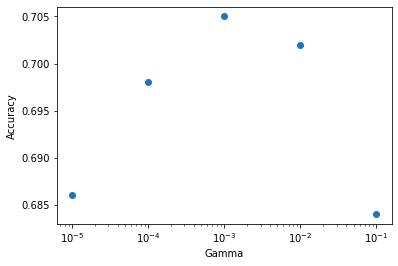

In [106]:
import matplotlib.pyplot as plt
#plt.scatter(map.T[0], map.T[1])
#plt.xscale("log")
fig, ax = plt.subplots()

ax.scatter(map.T[0], map.T[1])
ax.set_xlabel('Gamma')
ax.set_ylabel('Accuracy')
plt.xscale("log")
plt.show()

In [95]:
for n_estimators in [20, 30, 40]:
  #n_estimators = 24
  clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='rbf', probability=True, gamma=0.001, C=100, class_weight='balanced', max_iter=2000), n_jobs=-1, max_samples=1.0 / n_estimators, n_estimators=n_estimators))
  clf.fit(X_vec, y)
  print(f"{n_estimators}: {clf.score(X_t_vec, y_t)}")
#pre = clf.predict_proba(X_t_vec)

20: 0.718625
30: 0.712125


KeyboardInterrupt: ignored

In [54]:
pred = pre.argmax(axis=1)+1

In [55]:
pred

array([2, 2, 2, ..., 2, 2, 2])

In [56]:
accuracy_score(y_t, pred)

0.709375

# Knn tuning

In [57]:
from wrapped_model import U_trans_model, S_trans_model

In [ ]:
for i in range(18, 25, 2):
  print("-"*50)
  for j in range(31, 61, 5):
    for weights in ['distance']:
      clf = U_trans_model(KNeighborsClassifier(n_neighbors=j, weights='distance', n_jobs=-1), PCA(n_components=i))
      clf.fit(X_vec, y)
      print(f"{i}, {j}, {weights}: {clf.score(X_t_vec, y_t)}")
# best  ~ 67

--------------------------------------------------
18, 31, distance: 0.67425
18, 36, distance: 0.678375
18, 41, distance: 0.676
18, 46, distance: 0.6745
18, 51, distance: 0.673875
18, 56, distance: 0.67975
--------------------------------------------------
20, 31, distance: 0.679
20, 36, distance: 0.67975
20, 41, distance: 0.679
20, 46, distance: 0.679125
20, 51, distance: 0.678875
20, 56, distance: 0.678375
--------------------------------------------------
22, 31, distance: 0.67825
22, 36, distance: 0.678125
22, 41, distance: 0.677125
22, 46, distance: 0.675875
22, 51, distance: 0.67775


KeyboardInterrupt: ignored

In [59]:
knn = U_trans_model(KNeighborsClassifier(n_neighbors=39, weights='distance', n_jobs=-1), PCA(n_components=15))
knn.fit(X_vec, y)
pre2 = knn.predict_proba(X_t_vec)

In [61]:
pred2 = pre2.argmax(axis=1)+1

In [62]:
accuracy_score(y_t, pred2)

0.678375

In [85]:
pred

array([2, 2, 2, ..., 2, 2, 2])

Evaluating svm:
Accuracy = 70.94%
   Precision    Recall   F_score
1   0.719774  0.685868  0.702412
2   0.701596  0.799509  0.747359
3   1.000000  0.009852  0.019512

Confusion matrix:
      1     2  3
1  2417  1107  0
2   816  3254  0
3   125   277  4

--------------------------------------------------
Evaluating knn:
Accuracy = 67.84%
   Precision    Recall   F_score
1   0.636974  0.781215  0.701759
2   0.728607  0.646437  0.685067
3   0.641791  0.105911  0.181818

Confusion matrix:
      1     2   3
1  2753   767   4
2  1419  2631  20
3   150   213  43

--------------------------------------------------
Evaluating svm & knn
passing
Model svm accuracy : 0.709375
Model knn accuracy : 0.678375
Out of all predictions made,


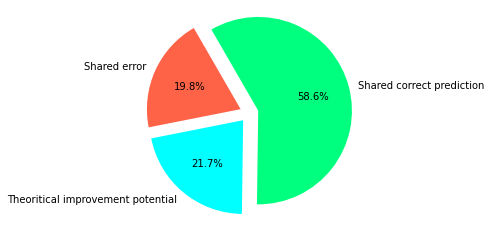

In [84]:
from evaluation import evaluate_models
evaluate_models([pred, pred2], y_t, titles=["svm", "knn"])

In [88]:
pre3 = pre * pre2

In [90]:
pre3

array([[9.32587107e-02, 3.67724755e-01, 7.01554073e-03],
       [4.94759781e-02, 5.35349041e-01, 1.79476067e-03],
       [4.84887140e-02, 5.53637300e-01, 0.00000000e+00],
       ...,
       [3.15645240e-02, 6.25764542e-01, 0.00000000e+00],
       [1.66762254e-01, 2.55677348e-01, 6.43330026e-03],
       [1.56552667e-01, 3.19417968e-01, 6.21121824e-04]])

In [91]:
pred3 = pre3.argmax(axis=1)+1

In [92]:
accuracy_score(y_t, pred3)

0.7075

50 knn: 15, 35

100 knn: 15, 30

# Log tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# define models and parameters
model = LogisticRegression(max_iter=2000)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=None, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_50, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.650594 using {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.650281 (0.002259) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.650313 (0.002207) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.650344 (0.001799) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.650281 (0.002259) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.650219 (0.002202) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.650406 (0.001892) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.650250 (0.002235) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.650312 (0.002203) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.650438 (0.001802) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.650563 (0.002272) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.650594 (0.002318) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.650031 (0.002079) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.650250 (0.002287) with: {

In [ ]:
# define models and parameters
model = LogisticRegression(max_iter=2000)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=None, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_100, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# others

In [ ]:
X_t_cv = X_t_cv.toarray().astype(np.float32)
X_cv = X_cv.toarray().astype(np.float32)
print(X_cv.shape)

(32000, 17967)


In [ ]:
pd.concat([X, pd.DataFrame(y.values, columns=['duration_label'])], axis=1).to_csv(path+"data/meta_train.csv", header=True, index=False)
pd.concat([X_t, pd.DataFrame(y_t.values, columns=['duration_label'])], axis=1).to_csv(path+"data/meta_test.csv", header=True, index=False)



---


In [ ]:
X = pd.read_csv(path+"data/meta_train.csv", header=0)
X_t = pd.read_csv(path+"data/meta_test.csv", header=0)

l = X.values.shape[1]

In [ ]:
f50 = [i for i in X.columns if '50' in i]
f100 = [i for i in X.columns if '100' in i]
fcv = [i for i in X.columns if 'cv' in i]

In [ ]:
models = [    
          MultinomialNB(),
          
          RandomForestClassifier(max_depth=5),

          RandomForestClassifier(max_depth=7),

          svm.SVC(kernel='rbf', gamma=0.7, C=1, max_iter=20000),

          svm.SVC(kernel='poly', gamma=0.7, C=1, max_iter=20000),
          
          LogisticRegression(max_iter=20000)]

titles = [    
          'MNB',
          
          'Random Forest 5',

          'RF 7',

          'svm rbf',

          'svm poly'
          
          'Logistic Regression']

In [ ]:
# evaluation

#a = X.loc[:, f50]
#b = X_t.loc[:, f50]

length = X.values.shape[1]

for i in range(0, length, 3):
  proba = X_t.iloc[:, i:i+3]
  print(proba.columns)
  yhat = np.argmax(proba.values, axis=1)+1
  print(accuracy_score(y_t, yhat))


# for title,clf in zip(titles, models):
#     clf.fit(X, y)
#     print(title, "Accuracy:",clf.score(X_t, y_t))

Index(['50_GNB_1', '50_GNB_2', '50_GNB_3'], dtype='object')
0.613625
Index(['50_Random Forest_1', '50_Random Forest_2', '50_Random Forest_3'], dtype='object')
0.66525
Index(['50_KNN5_1', '50_KNN5_2', '50_KNN5_3'], dtype='object')
0.633375
Index(['50_Logistic Regression_1', '50_Logistic Regression_2',
       '50_Logistic Regression_3'],
      dtype='object')
0.648375
Index(['50_lgb_1', '50_lgb_2', '50_lgb_3'], dtype='object')
0.694625
Index(['100_Random Forest_1', '100_Random Forest_2', '100_Random Forest_3'], dtype='object')
0.662125
Index(['100_Logistic Regression_1', '100_Logistic Regression_2',
       '100_Logistic Regression_3'],
      dtype='object')
0.671375
Index(['100_lgb_1', '100_lgb_2', '100_lgb_3'], dtype='object')
0.7025
Index(['cv_lgb_1', 'cv_lgb_2', 'cv_lgb_3'], dtype='object')
0.81175
Index(['cv_MNB_1', 'cv_MNB_2', 'cv_MNB_3'], dtype='object')
0.728375
Index(['cv_Random Forest_1', 'cv_Random Forest_2', 'cv_Random Forest_3'], dtype='object')
0.731125
Index(['cv_Logistic R

In [ ]:
clf=svm.SVC(kernel='rbf', gamma=0.7, C=1)
clf.fit(X, y)
clf.score(X_t, y_t)

0.759875

In [ ]:
clf=svm.SVC(kernel='poly', gamma=0.7, C=1)
clf.fit(X, y)
clf.score(X_t, y_t)

0.72975

In [ ]:
clf=LogisticRegression(max_iter=2000)
clf.fit(X, y)
clf.score(X_t, y_t)

0.766125

In [ ]:
clf=MultinomialNB()
clf.fit(X, y)
clf.score(X_t, y_t)

0.778875

In [ ]:
clf=GaussianNB()
clf.fit(X, y)
clf.score(X_t, y_t)

0.76375

In [ ]:
clf=DecisionTreeClassifier()
clf.fit(X, y)
clf.score(X_t, y_t)

0.699375

In [ ]:
params={}
params['learning_rate']=0.03
params['device_type']='cpu',
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=3
params['num_class']=3
params['verbosity']=-1

d_train=lgb.Dataset(a, label=y-1)

for i in range(5, 80, 10):


  clf=lgb.train(params,d_train, i)

  pre = clf.predict(b)

  yhat = np.argmax(pre, axis=1)+1
  print(f"{i}: {accuracy_score(y_t, yhat)}")

5: 0.660375
15: 0.672125
25: 0.672375
35: 0.669375
45: 0.668875
55: 0.67175
65: 0.672875
75: 0.671875




---



---



In [ ]:
class ScalerModel():
  """For countvectorier,
  transforms data with MaxAbsScaler before applying the model"""
  
  def __init__(self, model, max_iter=2000):
    self.transformer = MaxAbsScaler()
    if max_iter:
      self.clf = model(max_iter=max_iter)
    else:
      self.clf = model()
  
  def fit(self, X, y):
    X = self.transformer.fit_transform(X)
    self.clf.fit(X, y)
  

  def predict(self, X_t):
    X_t = self.transformer.transform(X_t)
    return self.clf.predict(X_t)

  def predict_proba(self, X_t):
    X_t = self.transformer.transform(X_t)
    return self.clf.predict_proba(X_t)
  
  def score(self, X_t, y_t):
    X_t = self.transformer.transform(X_t)
    return self.clf.score(X_t, y_t)

In [ ]:
models_vec = [GaussianNB(), RandomForestClassifier(max_depth=10), KNeighborsClassifier(n_neighbors=5), LogisticRegression(max_iter=2000)]
titles_vec = ['GNB', 'Random Forest', 'KNN5', 'Logistic Regression']

models_cv = [MultinomialNB(), RandomForestClassifier(max_depth=10), ScalerModel(LogisticRegression, max_iter=2000)]
titles_cv = ['MNB', 'Random Forest', 'Logistic Regression']

In [ ]:
train_meta = pd.read_csv(path+"data/meta_train.csv", header=0)
test_meta = pd.read_csv(path+"data/meta_test.csv", header=0)

In [ ]:
params={}
params['learning_rate']=0.03
params['device_type']='cpu',
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=10
params['num_class']=3
params['verbosity']=-1

In [ ]:
# 50
d_train=lgb.Dataset(X_50, label=y-1)
clf=lgb.train(params,d_train,400)

train_pred = clf.predict(X_50)
train_pred = pd.DataFrame(data=train_pred, columns=[f"{50}_lgb_{i+1}" for i in range(3)])

test_pred = clf.predict(X_t_50)
test_pred = pd.DataFrame(data=test_pred, columns=[f"{50}_lgb_{i+1}" for i in range(3)])

train_meta = pd.concat([train_meta, train_pred], axis=1)
test_meta = pd.concat([test_meta, test_pred], axis=1)

# 100
d_train=lgb.Dataset(X_100, label=y-1)
clf=lgb.train(params,d_train,500)

train_pred = clf.predict(X_100)
train_pred = pd.DataFrame(data=train_pred, columns=[f"100_lgb_{i+1}" for i in range(3)])

test_pred = clf.predict(X_t_100)
test_pred = pd.DataFrame(data=test_pred, columns=[f"100_lgb_{i+1}" for i in range(3)])

train_meta = pd.concat([train_meta, train_pred], axis=1)
test_meta = pd.concat([test_meta, test_pred], axis=1)



---



In [ ]:
from sklearn.feature_selection import f_classif, SelectKBest
selector = SelectKBest(f_classif, k=5000)
x = selector.fit_transform(X_cv, y)
x_t = selector.transform(X_t_cv)

In [ ]:
x

<32000x5000 sparse matrix of type '<class 'numpy.float32'>'
	with 1741397 stored elements in Compressed Sparse Row format>



---



In [ ]:
d_train=lgb.Dataset(x, label=y-1)
clf=lgb.train(params,d_train,400)

# train_pred = clf.predict(X_cv)
# train_pred = pd.DataFrame(data=train_pred, columns=[f"cv_lgb_{i+1}" for i in range(3)])

test_pred = clf.predict(x_t)
# test_pred = pd.DataFrame(data=test_pred, columns=[f"cv_lgb_{i+1}" for i in range(3)])

# train_meta = pd.concat([train_meta, train_pred], axis=1)
# test_meta = pd.concat([test_meta, test_pred], axis=1)

In [ ]:
accuracy_score(y_t, test_pred.argmax(axis=1)+1)

0.777125

In [ ]:
train_meta.to_csv(path+"data/meta_train.csv", header=True, index=False)
test_meta.to_csv(path+"data/meta_test.csv", header=True, index=False)

In [ ]:
models_vec = [GaussianNB(), PCA_knn(KNeighborsClassifier, 15, 30, 'distance')]
titles_vec = ['GNB', 'KNN']

In [ ]:
def return_proba(models, titles, X, y, X_t, X_name, lgb_params):
    
    train_out = pd.DataFrame(range(X.shape[0]))
    test_out = pd.DataFrame(range(X_t.shape[0]))
    
    for model, title in zip(models, titles):

        model.fit(X, y)

        train_pred = model.predict_proba(X)
        train_pred = pd.DataFrame(data=train_pred, columns=[f"{X_name}_{title}_{i+1}" for i in range(3)])

        test_pred = model.predict_proba(X_t)
        test_pred = pd.DataFrame(data=test_pred, columns=[f"{X_name}_{title}_{i+1}" for i in range(3)])

        train_out = pd.concat([train_out, train_pred], axis=1)
        test_out = pd.concat([test_out, test_pred], axis=1)
    
    # lgb
    d_train=lgb.Dataset(X, label=y-1)
    clf=lgb.train(lgb_params, d_train, 400)

    train_pred = clf.predict(X)
    train_pred = pd.DataFrame(data=train_pred, columns=[f"{X_name}_lgb_{i+1}" for i in range(3)])

    test_pred = clf.predict(X_t)
    test_pred = pd.DataFrame(data=test_pred, columns=[f"{X_name}_lgb_{i+1}" for i in range(3)])
    
    train_out = pd.concat([train_out, train_pred], axis=1)
    test_out = pd.concat([test_out, test_pred], axis=1)
    
    # drop dummy column & return
    train_out.drop(0, axis=1, inplace=True)
    test_out.drop(0, axis=1, inplace=True)
    
    return train_out, test_out

In [ ]:
x, x_t = return_proba(models_vec, titles_vec, X_50, y, X_t_50, '50', params)

In [ ]:
length = x_t.values.shape[1]

for i in range(0, length, 3):
  proba = x_t.iloc[:, i:i+3]
  print(proba.columns)
  yhat = np.argmax(proba.values, axis=1)+1
  print(accuracy_score(y_t, yhat))

Index(['50_GNB_1', '50_GNB_2', '50_GNB_3'], dtype='object')
0.613625
Index(['50_KNN_1', '50_KNN_2', '50_KNN_3'], dtype='object')
0.669875
Index(['50_lgb_1', '50_lgb_2', '50_lgb_3'], dtype='object')
0.694625


In [ ]:
for title,clf in zip(titles, models):
    clf.fit(x, y)
    print(title, "Accuracy:",clf.score(x_t, y_t))

MNB Accuracy: 0.682375
Random Forest 5 Accuracy: 0.663625
RF 7 Accuracy: 0.661125
svm rbf Accuracy: 0.660125
svm polyLogistic Regression Accuracy: 0.661625


In [ ]:
def proba_2_pred(probas):

  length = probas.values.shape[1]
  out = pd.DataFrame(range(probas.shape[0]))

  for i in range(0, length, 3):
    proba = X_t.iloc[:, i:i+3]
    yhat = pd.Series(np.argmax(proba.values, axis=1)+1, name=f'{proba.columns[0][:-2]}')
    out = pd.concat([out, yhat], axis=1)
  
  out.drop(0, axis=1, inplace=True)
  return out

In [ ]:
predictions = proba_2_pred(x_t)

0       2
1       2
2       2
3       2
4       1
       ..
7995    1
7996    3
7997    1
7998    2
7999    2
Name: 50_GNB, Length: 8000, dtype: int64
         0  50_GNB
0        0       2
1        1       2
2        2       2
3        3       2
4        4       1
...    ...     ...
7995  7995       1
7996  7996       3
7997  7997       1
7998  7998       2
7999  7999       2

[8000 rows x 2 columns]
0       2
1       2
2       2
3       2
4       1
       ..
7995    1
7996    2
7997    2
7998    2
7999    1
Name: 50_Random Forest, Length: 8000, dtype: int64
         0  50_GNB  50_Random Forest
0        0       2                 2
1        1       2                 2
2        2       2                 2
3        3       2                 2
4        4       1                 1
...    ...     ...               ...
7995  7995       1                 1
7996  7996       3                 2
7997  7997       1                 2
7998  7998       2                 2
7999  7999       2          

In [ ]:
y = pd.DataFrame([0, 1, 0, 0, 1, 0])

x = pd.DataFrame([1, 1, 0, 1, 1, 1])
z = pd.DataFrame([0, 0, 0, 0, 0, 0])

Model A accuracy : 0.5
Model B accuracy : 0.5
Out of all predictions made,


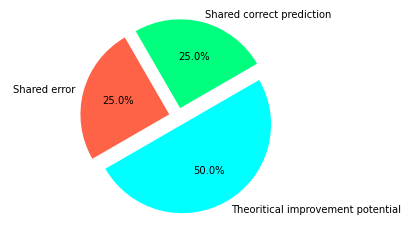

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from itertools import combinations
import matplotlib.pyplot as plt

def shared_error(pred_a, pred_b):
  print(f"Model A accuracy : {pred_a.sum()/len(pred_a.index)}")
  print(f"Model B accuracy : {pred_b.sum()/len(pred_b.index)}")

  TT = TF = FF = 0

  length = len(pred_a.index)

  for i in range(length):
    a = pred_a[i]
    b = pred_b[i]
    if a and b:
      TT += 1
    elif not (a or b):
      FF += 1
    else:
      TF += 1

  print(f"Out of all predictions made,")

  # Pie chart
  labels = 'Shared error', 'Theoritical improvement potential', 'Shared correct prediction'
  sizes = [FF, TF, TT]
  explode = (0.1, 0.1, 0.1)  # only "explode" the 2nd slice
  colors = ['tomato', 'cyan', 'springgreen']

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, explode=explode, colors=colors, labels=labels, autopct='%1.1f%%', startangle=120)
  ax1.axis('equal')

  plt.show()
shared_error(pred_a, pred_b)

In [ ]:
pred_a = pd.Series([True, True, False, False])
pred_b = pd.Series([False, True, True, False])

In [ ]:
def simple_error_analysis(predictions, y):
  num = predictions.values.shape[1]

  for comb in combinations([i for i in range(3)], 2):
    a = predictions.iloc[:, comb[0]]
    b = predictions.iloc[:, comb[1]]
    shared_error(a, b, y)
    
simple_error_analysis(predictions, y_t)

Pred a accuracy : 0.613625
Pred b accuracy : 0.66525
Shared error to a: [0.6725168  0.75760992]
Shared error to b: [0.58265933 0.82134854]
Pred a accuracy : 0.613625
Pred b accuracy : 0.633375
Shared error to a: [0.58643028 0.7294257 ]
Shared error to b: [0.55645422 0.75290283]
Pred a accuracy : 0.66525
Pred b accuracy : 0.633375
Shared error to a: [0.53562905 0.78152753]
Shared error to b: [0.58663181 0.74408117]


In [ ]:
shared_error(x, z, y)

Pred a accuracy : 0.5
Pred b accuracy : 0.6666666666666666
Shared error to a: 0.25
Shared error to b: 0.3333333333333333


In [ ]:
error_correlation()

In [ ]:
x = pd.concat([train_meta, x], axis=1)
x_t = pd.concat([test_meta, x_t], axis=1)

In [ ]:
a, b = return_proba(models_vec, titles_vec, X_100, y, X_t_100, '100')

In [ ]:
x = pd.concat([x, a], axis=1)
x_t = pd.concat([x_t, b], axis=1)

In [ ]:
x.to_csv(path+"data/meta_train.csv", header=True, index=False)
x_t.to_csv(path+"data/meta_test.csv", header=True, index=False)

In [ ]:
x

,50_GNB_1,50_GNB_2,50_GNB_3,50_Random Forest_1,50_Random Forest_2,50_Random Forest_3,50_KNN5_1,50_KNN5_2,50_KNN5_3,50_Logistic Regression_1,50_Logistic Regression_2,50_Logistic Regression_3,100_GNB_1,100_GNB_2,100_GNB_3,100_Random Forest_1,100_Random Forest_2,100_Random Forest_3,100_KNN5_1,100_KNN5_2,100_KNN5_3,100_Logistic Regression_1,100_Logistic Regression_2,100_Logistic Regression_3
0,0.852188,0.141965,0.005847,0.582906,0.382925,0.034169,0.6,0.4,0.0,0.555746,0.432926,0.011328,8.872638e-01,0.111816,0.000921,0.401644,0.561908,0.036448,0.6,0.4,0.0,0.456654,0.522725,0.020620
1,0.915978,0.047179,0.036843,0.395433,0.506076,0.098491,0.8,0.2,0.0,0.501415,0.445211,0.053374,9.665422e-01,0.027176,0.006282,0.424886,0.529713,0.045401,0.6,0.4,0.0,0.517560,0.473088,0.009352
2,0.991453,0.008394,0.000153,0.629837,0.336341,0.033821,0.6,0.4,0.0,0.588505,0.404018,0.007476,9.999254e-01,0.000072,0.000003,0.631872,0.331578,0.036551,1.0,0.0,0.0,0.516473,0.475189,0.008338
3,0.340087,0.569486,0.090427,0.460555,0.489942,0.049502,0.8,0.0,0.2,0.308115,0.537405,0.154480,9.179669e-01,0.049480,0.032553,0.490463,0.463474,0.046063,0.8,0.2,0.0,0.295350,0.297050,0.407600
4,0.998008,0.001734,0.000259,0.776243,0.192616,0.031141,1.0,0.0,0.0,0.599515,0.385475,0.015010,9.999968e-01,0.000002,0.000002,0.770201,0.189016,0.040783,1.0,0.0,0.0,0.632349,0.351608,0.016043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,0.973237,0.026422,0.000340,0.678114,0.292433,0.029453,0.8,0.2,0.0,0.817899,0.174632,0.007469,9.886429e-01,0.011289,0.000068,0.592016,0.367318,0.040666,1.0,0.0,0.0,0.858937,0.136827,0.004237
31996,0.000192,0.914792,0.085016,0.176756,0.550995,0.272249,0.0,0.8,0.2,0.030113,0.692407,0.277480,1.390635e-08,0.821211,0.178789,0.246071,0.485365,0.268565,0.4,0.2,0.4,0.041580,0.723788,0.234632
31997,0.769546,0.230305,0.000149,0.399243,0.552795,0.047963,0.4,0.6,0.0,0.642531,0.355667,0.001803,2.371396e-01,0.762761,0.000100,0.360200,0.594867,0.044933,0.6,0.4,0.0,0.486079,0.511866,0.002055
31998,0.984066,0.012529,0.003405,0.677217,0.279899,0.042884,0.8,0.2,0.0,0.368771,0.597087,0.034142,9.996216e-01,0.000335,0.000044,0.524072,0.425289,0.050639,1.0,0.0,0.0,0.368390,0.620261,0.011349


In [ ]:
from sklearn.metrics import accuracy_score

np.random.seed(42)

class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X)
        self.metaclassifier.fit(X_meta, y)
    
    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        assert yhats.shape[0] == X.shape[0]
        return yhats
    
    def predict(self, X):
        X_meta = self._predict_base(X)     
        yhat = self.metaclassifier.predict(X_meta)
        return yhat
    
    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)

In [ ]:
meta_classifier = svm.SVC(kernel='rbf', gamma=0.7, C=1)
stacker = StackingClassifier(models, meta_classifier)

In [ ]:
for title,clf in zip(titles, models):
    clf.fit(X_50, y)
    print(title, "Accuracy:",clf.score(X_t_50, y_t))
    
stacker.fit(X_50, y)
print('\nStacker Accuracy:', stacker.score(X_t_50, y_t))

GNB Accuracy: 0.613625
Decision Tree Accuracy: 0.599875
Random Forest Accuracy: 0.646625
KNN3 Accuracy: 0.62425
KNN5 Accuracy: 0.633375
KNN7 Accuracy: 0.63425
Logistic Regression Accuracy: 0.649375


In [ ]:
# doc2vec 50: GNB, RF, KNN, LR

In [ ]:
for title,clf in zip(titles, models):
    clf.fit(X_100, y)
    print(title, "Accuracy:",clf.score(X_t_100, y_t))
    
stacker.fit(X_100, y)
print('\nStacker Accuracy:', stacker.score(X_t_100, y_t))

GNB Accuracy: 0.599875
Decision Tree Accuracy: 0.583
Random Forest Accuracy: 0.644125
KNN3 Accuracy: 0.572
KNN5 Accuracy: 0.569375
KNN7 Accuracy: 0.563625


c:\users\25791\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression Accuracy: 0.671875


c:\users\25791\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\25791\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\25791\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/


Stacker Accuracy: 0.670875


In [ ]:
# doc2vec 100: GNB, RF, KN3, LG

In [ ]:
models = [    
          MultinomialNB(),
          
          RandomForestClassifier(max_depth=20),
          
          LogisticRegression(max_iter=2000)]

titles = [    
          'MNB',
          
          'Random Forest 20',
          
          'Logistic Regression']

for title,clf in zip(titles, models):
    clf.fit(X_cv, y)
    print(title, "Accuracy:",clf.score(X_t_cv, y_t))
    
stacker.fit(X_cv, y)
print('\nStacker Accuracy:', stacker.score(X_t_cv, y_t))

MNB Accuracy: 0.728375
Random Forest 20 Accuracy: 0.75
Logistic Regression Accuracy: 0.780375


NameError: ignored

In [ ]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X_cv, y)
clf.score(X_t_cv, y_t)

0.793625